# 一、从零实现一个线性模型

# 1. 构造一个数据集

In [27]:
import random
import numpy as np
import torch

In [83]:
#手工构造一个数据集
# y = Wx+b+e

def synthetic_data(w, b, num_examples):
    """
    w: a list of weights
    b: bias
    num_examples: namely
    """
    X = np.random.normal(0, 1,(num_examples, len(w)))  # X服从0~1的正态分布
    y = np.matmul(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)  # 添加噪音
    return X, y.reshape((-1, 1))

w_true = np.array([2, -3.4])
b_true = 4.2
features, labels = synthetic_data(w_true, b_true, 1000)

In [58]:
print(features.shape)
features[:5], labels[:5]

(1000, 2)


(array([[-1.89514136, -0.05785525],
        [-0.2005648 ,  0.60202221],
        [ 1.04071886, -1.62725927],
        [ 0.72767983,  1.28517374],
        [-0.90566961,  1.29478896]]),
 array([[ 0.58655753],
        [ 1.75160523],
        [11.80399827],
        [ 1.28593393],
        [-2.01440084]]))

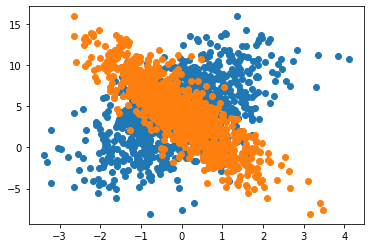

In [59]:
import matplotlib.pyplot as plt
plt.scatter(features[:, 0], labels)
plt.scatter(features[:, 1], labels)

# 2.构建批量采样函数、模型、损失函数、优化算法

In [60]:
# 数据采样函数
def data_iter(batch_size, features, labels):
    assert len(features) == len(labels), "not match"
    num_examples = len(labels)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):  # 今天才知道range函数还有第三个参数可选！！
        batch_features = features[i : i + batch_size]
        batch_labels = labels[i : i + batch_size]
        yield batch_features, batch_labels

In [61]:
for X, y in data_iter(4,list(range(12)),[1]*12):
    print(X, y)

[0, 1, 2, 3] [1, 1, 1, 1]
[4, 5, 6, 7] [1, 1, 1, 1]
[8, 9, 10, 11] [1, 1, 1, 1]


In [62]:
# 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [63]:
# 定义损失函数
def squared_loss(y_true, y_pred):
    return torch.sum((y_true - y_pred)**2)/2

In [64]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """
    params: a list of params
    """
    with torch.no_grad():  # 设置停止torch的梯度记录
        for param in params:
            param -= lr * param.grad / batch_size  # 等价于在loss中除以batch_size
            param.grad.zero_()  # 重置该参数的梯度，便于下一次计算

# 3.进行训练

In [65]:
lr = 0.01
epochs = 100
batch_size = 100
model = linreg
loss_func = squared_loss

# 参数初始化
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# numpy的数据默认格式为float64，但torch中默认使用float32
# 同时，torch模型也不能直接处理numpy数据，需要进行格式转换
features = torch.tensor(features, dtype=torch.float32)  
labels = torch.tensor(labels, dtype=torch.float32)

for i in range(epochs):
    for X, y in data_iter(batch_size, features, labels):
        y_pred = model(X, w, b)
        l = loss_func(y, y_pred)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        if i % 10 == 0:
            epoch_loss = loss_func(model(features, w, b), labels)
            print(f'epoch {i + 1}, loss {float(epoch_loss)}')

epoch 1, loss 13399.2265625
epoch 11, loss 1865.0733642578125
epoch 21, loss 260.1598205566406
epoch 31, loss 36.40078353881836
epoch 41, loss 5.138577461242676
epoch 51, loss 0.76097571849823
epoch 61, loss 0.1465410739183426
epoch 71, loss 0.060093529522418976
epoch 81, loss 0.0479029044508934
epoch 91, loss 0.04618138074874878


In [74]:
# 由于w带了requires_grad属性，所以要转化成numpy，需要先detach
print(f'w的估计误差: {w_true - w.detach().numpy().reshape(w_true.shape)}')
print(f'b的估计误差: {b_true - float(b.detach())}')

w的估计误差: [-0.0004003  -0.00041475]
b的估计误差: -4.100799560369239e-06


# 二、利用框架快速实现

In [85]:
import numpy as np
import torch
from torch.utils import data

In [87]:
features = torch.tensor(features, dtype=torch.float32)  
labels = torch.tensor(labels, dtype=torch.float32)

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

## 简单提一下这里的`TensorDataset`和`DataLoader`
`TensorDataset`这玩意儿，我不是很懂有什么大作用。感觉必须配合`DataLoader`使用，因为`Dataloader`接受的就是Dataset格式的输入。\
另外，`TensorDataset`的输入，最常见的就是`(X, y)`，然后返回的dataset就是把二者打包的结果

In [101]:
# 看看TensorDataset在干嘛：
X = torch.tensor([[1,2,3],[1,2,2],[3,2,1]])  # 样本的特征
y = torch.tensor([1,2,1])  # 样本的标签
dataset = data.TensorDataset(X, y)
print(dataset[:])  # 可以看到，就是把输入的X和y打包了，方便DataLoader直接使用

(tensor([[1, 2, 3],
        [1, 2, 2],
        [3, 2, 1]]), tensor([1, 2, 1]))


In [113]:
data_iter = data.DataLoader(dataset, batch_size=2)
f = iter(data_iter)
next(f),next(f)

([tensor([[1, 2, 3],
          [1, 2, 2]]),
  tensor([1, 2])],
 [tensor([[3, 2, 1]]), tensor([1])])

In [89]:
from torch import nn
model = nn.Sequential(nn.Linear(2, 1))

model[0].weight.data.normal_(0, 0.01)  #  model[0]代表取出模型的第一层，使用.normal_或者.fill_来赋值
model[0].bias.data.fill_(0)

tensor([0.])

In [90]:
# 设置损失函数、优化器
loss = nn.MSELoss()
trainer = torch.optim.SGD(model.parameters(), lr=0.01)

In [91]:
epochs = 10
for i in range(epochs):
    for X, y in data_iter:
        y_pred = model(X)
        l = loss(y_pred, y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    epoch_l = loss(model(features), labels)
    print(f'epoch {i}, loss {epoch_l}')

epoch 0, loss 0.6866896152496338
epoch 1, loss 0.01537397038191557
epoch 2, loss 0.00043629383435472846
epoch 3, loss 0.00010447522799950093
epoch 4, loss 9.759785461938009e-05
epoch 5, loss 9.739570668898523e-05
epoch 6, loss 9.748060256242752e-05
epoch 7, loss 9.744378621689975e-05
epoch 8, loss 9.740984387462959e-05
epoch 9, loss 9.75194270722568e-05
